In [79]:
.mySampleScoreArrangerFn=function(inputPath){
  #This function reads in the sample scores (between 0 and 1)
  # inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/"
  # inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/"
    print(paste0("Path is ",inputPath))
  resCombined=list()
  # tmpFiles=list.files(inputPath)
  tmpFiles = read.table(paste0(inputPath,"dataList.txt"))
  if (length(strsplit(as.character(tmpFiles$V1[1]),"/")[[1]])>2){
    path=''
  }else{
  path=unlist(strsplit(inputPath,"/"))
  path=path[-length(path)]
  path=paste(path,collapse = "/")
  path=paste0(path,"/")
    }
  
  # tmpFiles = as.vector(tmpFiles)
  if((length(tmpFiles))!=25){
    print(paste("caution: number of files is",(length(tmpFiles$V1))))
  }
  print(paste0("Path is ",path))
  for(i in 1:(length(tmpFiles$V1))){
    # 
    # strsplit(status,"_")

    load(paste0(path,tmpFiles$V1[i],"results.rda"))
    
    tmp=result$ROCdf
    
    resdf=list()
    for(j in 1:length(tmp)){
      #print(j)
      tmpdf=tmp[[j]][[1]]
      tmpdf$status=tmp[[j]][[2]]
      colnames(tmpdf)=c("sampleName","real","estimated","status")
      resdf=c(resdf,list(tmpdf))
    }
    resdf=do.call("rbind",resdf)
    resdf=resdf[!duplicated(paste0(resdf$sampleName,"_",resdf$status)),]
    resCombined=c(resCombined,list(resdf))
  }
  
  return(resCombined)
}
.myClassificationEvaluationFn=function(testLabelsHat,testLabels){
  require(PRROC,quietly=T)
  require(pROC,quietly=T)
  
  finalResPR=pr.curve(scores.class0=testLabelsHat,weights.class0=testLabels)$auc.integral
  finalResROC=as.numeric(roc(response=testLabels,predictor=as.vector(testLabelsHat))$auc)
  
  return(list(ROC=finalResROC,PR=finalResPR,ROCdata=roc(response=testLabels,predictor=as.vector(testLabelsHat)),PRdata=pr.curve(scores.class0=testLabelsHat,weights.class0=testLabels)))
}
.myResultOrganizerFn=function(inputPath,countThr=NULL,replaceZero=F){
  #results with number of folds less than the countThr are set to zero
  #zeros can be replaced with 0.5 (ROC and PR)
  load(inputPath)
  inputData=ROCres
  
  if(is.null(countThr)){
    countThr=max(inputData[[2]])
  }
  
  inputData[[1]][inputData[[2]]<countThr]=0
  if(replaceZero){
    inputData[[1]][inputData[[1]]==0]=0.5
  }
  res=inputData[[1]]
  
  thr=0
  if(replaceZero){
    thr=0.5
  }
  x=apply(res,1,function(x) sum(x==thr))
  res=res[which(x<(ncol(inputData[[1]])-1)),]
  return(res)
}
library(ggplot2)
library(reshape2)
library(limma)
library(gplots)

.myDataArrangerFn=function(inputPath,inputROCthr=0.7,inputROCPower=2,colorset=c("black","red"),wCompleteDS=F, overlapped_model=NULL,make_composite=F ){
  #data$average: simple average of sample scores across folds for the same subject with the same features+classifier
  #data$concensus: concensus scores of models with ROCthr >inputROCthr
  # inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/"
  # inputROCthr=0.7
  # inputROCPower=2
  # colorset=c("black","red")
  # wCompleteDS=F
#   inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/ld_runner/"
  # load(paste0(inputPath,"ResultsArranged.rda"))
  weightsROC=.myResultOrganizerFn(paste0(inputPath,"ResultsArranged.rda"),replaceZero = T)
  load(paste0(inputPath,"ResultsArranged.rda"))
  PRs=PRres[[1]]
  PRs=PRs[row.names(PRs) %in% row.names(weightsROC),]
  PRs_counts=PRres[[2]]
  PRs_counts=PRs_counts[row.names(PRs_counts) %in% row.names(weightsROC),]
  PRs=PRs[,-which(colnames(PRs)=="sqda")]
  PRs_counts=PRs_counts[,-which(colnames(PRs_counts)=="sqda")]
  
  ROCs=ROCres[[1]]
  ROCs=ROCs[row.names(ROCs) %in% row.names(weightsROC),]
  ROCs_counts=ROCres[[2]]
  ROCs_counts=ROCs_counts[row.names(ROCs_counts) %in% row.names(weightsROC),]
  ROCs=ROCs[,-which(colnames(ROCs)=="sqda")]
  ROCs_counts=ROCs_counts[,-which(colnames(ROCs_counts)=="sqda")]
  
  countThr=max(ROCs_counts)
  slInd=as.data.frame(which(ROCs_counts<countThr,arr.ind = T))
  slInd=unique(slInd$row)
  weightsROC=weightsROC[-which(row.names(weightsROC) %in% row.names(ROCs_counts)[slInd]),]
  ROCs=ROCs[-which(row.names(ROCs) %in% row.names(ROCs_counts)[slInd]),]
  PRs=PRs[-which(row.names(PRs) %in% row.names(ROCs_counts)[slInd]),]
  PRs_counts=PRs_counts[-which(row.names(PRs_counts) %in% row.names(ROCs_counts)[slInd]),]
  ROCs_counts=ROCs_counts[-which(row.names(ROCs_counts) %in% row.names(ROCs_counts)[slInd]),]
  if(sum(colnames(weightsROC)=="sqda")>0){
    weightsROC=weightsROC[,-which(colnames(weightsROC)=="sqda")]
  }
  
  print("Number of models:")
  print(dim(weightsROC))
  
  print("max scores per classifier:")
  print(apply(weightsROC,2,max))
  pdf(file=paste0(inputPath,"boxplot.pdf"))
  boxplot(weightsROC,legend = F)
  dev.off()
  data=.mySampleScoreArrangerFn(inputPath)

  #   
  # ROCmat=ROCres
  # ROCmat=ROCmat[,-which(colnames(ROCmat)=="sqda")]
  # slpallete=c(blue2green(9),colorRampPalette(c("green", "yellow"))(9)[-1],colorRampPalette(c("yellow", "red"))(6)[-1])
  # hm=heatmap.2(as.matrix(ROCmat), margins = c(5,10),trace="none",density.info=c("none"),col=slpallete[max(round(min(ROCmat),1)*25,2):(round(max(ROCmat),2)*25)],labRow = F)
  # #finding high performing cluster
  # ##set k in a way that separates the high performing cluster
  # 
  # k=5
  # n=cutree(as.hclust(hm$rowDendrogram),k)
  # nPalette=WGCNA:::labels2colors(seq(1:k))
  # #nPalette[4]="black"
  # 
  # nPalette=nPalette[n]
  # 
  # #nPalette[nPalette=="brown"]="orange"
  # 
  # heatmap.2(as.matrix(ROCmat), margins = c(5,10),trace="none",density.info=c("none"),col=slpallete[max(round(min(ROCmat),1)*25,2):(round(max(ROCmat),2)*25)],labRow = F,RowSideColors=nPalette)
  # #correspondence of colors with cluster numbers
  # data.frame(Number=1:k,color=WGCNA:::labels2colors(seq(1:k)))
  # 
  # #which color?
  # slColor=4
  # slClusters=ROCmat[n==slColor,]
  # pathList=row.names(slClusters)
  # 
  # save(pathList,file=paste0(path,"selectedPathList.rda"))

  data=do.call("rbind",data)
  
  #removing the fold information from feature selection routes to allow the integration of results across folds
  status=gsub("^independent","^independent_1",data$status)
  status=strsplit(status,"_")
  status=unlist(lapply(status,function(x)paste(x[3:length(x)],collapse = "_")))
  data$statusUpdated=status #statusUpdated: feature selection route without info on the fold
  rm(status)
  
  #weighting the scores based on the model's ROC
  x=as.data.frame(weightsROC)
  x$id=row.names(x)
  x=reshape2::melt(x,by="id")
  
  x2=strsplit(x$id,"_")
  x2=unlist(lapply(x2,function(x)paste(x[2:length(x)],collapse = "_")))
  x2=paste0(x2,"_",as.character(x$variable))
  x2=gsub("independent","real",x2)
  # x2=gsub("perm1","real",x2)
  # x2=gsub("perm2","real",x2)
  # x2=gsub("perm3","real",x2)
  # x2=gsub("perm4","real",x2)
  # x2=gsub("perm5","real",x2)
  x$status=x2
  
  data=data[data$statusUpdated %in% x$status,]
  x=x[x$status %in% data$statusUpdated,]
  
  x=x[,c("status","value")]
  colnames(x)[2]="weightROC"
  data=merge(data,x,by.x='statusUpdated',by.y="status")
  rm(x)
  #tmp=as.data.frame(table(data$status[data$estimated>1]))
  #tmp=strsplit(as.character(tmp$Var1),"_")
  #tmp=unlist(lapply(tmp,function(x) x[length(x)]))
  
  data=data[which(data$estimated>=0 & data$estimated<=1),]
  data$id=paste0(data$statusUpdated,"_",data$sampleName)
  data=list(data=data)
  data$average=aggregate(estimated~id,data=data$data,FUN=mean)
  
  data3=data$data[,c("id","sampleName","real","statusUpdated","weightROC")]
  data3=data3[!duplicated(data3$id),]
  data3=merge(data$average,data3,by="id")
  
  data$average=data3
  rm(data3)
  
  #ref_data=melt(dataMain$data$weightsROC)
  #ref_data$status=paste0(ref_data[,1],"_",ref_data[,2])
  #ref_data=ref_data[,c(4,3)]
  #colnames(ref_data)=c("statusUpdated","ref_weightROC")
  #ref_data=ref_data[ref_data$ref_weightROC>median(ref_data$ref_weightROC),]
  #ref_data$statusUpdated=gsub("real_","",as.character(ref_data$statusUpdated))
  #tmp=merge(data$average,ref_data,by="statusUpdated")
  #tmp=tmp[!duplicated(tmp$statusUpdated),]

  data$average$modWeightROC=data$average$weightROC-0.7
  
  data$average$modWeightROC[which(data$average$modWeightROC<0)]=0
  if(make_composite){
    print(paste0(sum(data$average$statusUpdated %in% overlapped_model), " subjects used to make composite model"))
    data$average$modWeightROC[!which(data$average$statusUpdated %in% overlapped_model)]=0
  }
  data$average$weightedEstimate=data$average$estimated*(data$average$modWeightROC)^inputROCPower
  
  
  data3=data$average
  data3$dx=paste0(data3$statusUpdated,"_dx",data3$real)
  tmp=data3[,c("dx","real")]
  tmp=tmp[!duplicated(tmp$dx),]
  data3med=aggregate(weightedEstimate~dx,data=data3,median)
  data$overallSubjectMean=merge(data3med,tmp,by="dx")
  rm(tmp,data3med,data3)
  status=data$overallSubjectMean$dx
  status=strsplit(status,"_")
  status=unlist(lapply(status,function(x) paste(x[1:(length(x)-1)],collapse = "_")))
  data$overallSubjectMean$status=status
  rm(status)
  
  tmp=dcast(data = data$average,formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")

  df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
  df=df[!duplicated(df$sampleName),]
  df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,stringsAsFactors = F),by="sampleName")
  df=df[!duplicated(df$sampleName),]
  df=df[match(colnames(tmp)[-1],df$sampleName),]
  labelsVector=df$real
  labcol=rep("black",length(labelsVector))
  
  
  colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
  scale="none"
  main=""
  
  xx=as.matrix(dist(t(tmp[,-1])))
  xxx=cor(xx)
  labcol[labelsVector==0]=colorset[1]
  labcol[labelsVector==1]=colorset[2]
  pdf(file=paste0(inputPath,"heatmap.pdf"))
  hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),col=colramp,RowSideColors = labcol,hclustfun=function(d) stats::hclust(d, method="ward.D2"),distfun=function(x) as.dist(1-cor(t(x))), ColSideColors = labcol, margins = c(5,10),scale=scale,main=main,trace="none",density.info=c("none")) 
  #eval(hm$call)
  dev.off()
  tmp2=data$average[,c("sampleName","real")]
  tmp2=tmp2[!duplicated(tmp2$sampleName),]
  data$concensus=apply(tmp[,-1],2,sum)
  data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
  data$concensus=merge(data$concensus,tmp2,by="sampleName")

  data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
  data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
   
  print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
  print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
  print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
  print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
  print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

  data$weightsROC=weightsROC
  
#   dataSubjectId=data$concensus
#   if(wCompleteDS){
#     load("~/Documents/archive/dropbox_shared_tiziano/WG6/WG6_HT12_Complete.rda")
#   } else {
#     load("~/Documents/archive/dropbox_shared_tiziano/WG6/WG6_HT12_missingSomeSamples.rda")
#   }
#   
# dataSubjectId=merge(dataSubjectId,data.frame(subjectId=dataQuantile$subjectId,sampleName=colnames(dataQuantile),age=dataQuantile$age,diagnosis_binary=dataQuantile$diagnosis_binary),by='sampleName')
#   
# load("~/Documents/archive/UCSD_data/myData/LWdata.rda")
# LWdata$final_ADOS_CoSoTot[LWdata$DxJ_Count==1]=LWdata$ados_CoSoTot_1[LWdata$DxJ_Count==1]
# LWdata$final_ADOS_CoSoRRTot[LWdata$DxJ_Count==1]=LWdata$ados_CoSoTotRRTot_1[LWdata$DxJ_Count==1]
# 
# LWdata$final_ADOS_CoSoTot[is.na(LWdata$final_ADOS_CoSoTot)]=LWdata$ados_CoSoTot_1[is.na(LWdata$final_ADOS_CoSoTot)]
# 
# LWdata$final_ADOS_CoSoRRTot[is.na(LWdata$final_ADOS_CoSoRRTot)]=LWdata$ados_CoSoTotRRTot_1[is.na(LWdata$final_ADOS_CoSoRRTot)]
# 
# LWdata$final_mullen_ELC[is.na(LWdata$final_mullen_ELC)]=LWdata$mullen_ELC_Std_1[is.na(LWdata$final_mullen_ELC)]
# 
# LWdata$final_mullen_ELT[is.na(LWdata$final_mullen_ELT)]=LWdata$mullen_ELT_1[is.na(LWdata$final_mullen_ELT)]
# 
# LWdata$final_mullen_RLT[is.na(LWdata$final_mullen_RLT)]=LWdata$mullen_RLT_1[is.na(LWdata$final_mullen_RLT)]
# 
# LWdata$final_mullen_FMT[is.na(LWdata$final_mullen_FMT)]=LWdata$mullen_FMT_1[is.na(LWdata$final_mullen_FMT)]
# 
# LWdata$final_mullen_VRT[is.na(LWdata$final_mullen_VRT)]=LWdata$mullen_VRT_1[is.na(LWdata$final_mullen_VRT)]
# 
# LWdata$final_vine_AdapBehav_DomStd[is.na(LWdata$final_vine_AdapBehav_DomStd)]=LWdata$vine_AdapBehav_DomStd_1[is.na(LWdata$final_vine_AdapBehav_DomStd)]
# 
# dataSubjectId=merge(dataSubjectId,LWdata,by.x = "subjectId",by.y='subjectid')
# 
# if(nrow(data$concensus)!=nrow(dataSubjectId)){
#   print("error")
# }

# data$concensus=dataSubjectId
data$PR_values=PRs


xROC=as.data.frame(which(ROCs>0.8,arr.ind = T))
xPR=as.data.frame(which(PRs>0.8,arr.ind = T))

xROC=paste0(row.names(ROCs)[xROC$row],"-",colnames(ROCs)[xROC$col])
xPR=paste0(row.names(PRs)[xPR$row],"-",colnames(PRs)[xPR$col])

  return(list(data=data,heatmap=hm))
  
}

.myROCDensityDataFn=function(){
  xMain=data.frame(id=row.names(dataMain$data$weightsROC),dataMain$data$weightsROC,stringsAsFactors = F)
xMain=melt(xMain,id.vars = "id")
xMain$datasetName="Main"

xLong=data.frame(id=row.names(dataLong$data$weightsROC),dataLong$data$weightsROC,stringsAsFactors = F)
xLong=melt(xLong,id.vars = "id")
xLong$datasetName="Longitudinal"

xTest=data.frame(id=row.names(dataTest$data$weightsROC),dataTest$data$weightsROC,stringsAsFactors = F)
xTest=melt(xTest,id.vars = "id")
xTest$datasetName="Test"

xLD=data.frame(id=row.names(dataLD$data$weightsROC),dataLD$data$weightsROC,stringsAsFactors = F)
xLD=melt(xLD,id.vars = "id")
xLD$datasetName="LD"

xLD_ASD=data.frame(id=row.names(dataLD_ASD$data$weightsROC),dataLD_ASD$data$weightsROC,stringsAsFactors = F)
xLD_ASD=melt(xLD_ASD,id.vars = "id")
xLD_ASD$datasetName="LD_ASD"
ROCscombined=rbind(xMain,xTest,xLong,xLD,xLD_ASD)

return(ROCscombined)
}

.myAlternativeModelExplorerFn=function(inputData){
  # inputData=dataMain
  indxPoor=inputData$data$concensus$sampleName[inputData$data$concensus$weightedEstimate<0.75&inputData$data$concensus$real==1]
indxPoor=inputData$data$average[inputData$data$average$sampleName %in% indxPoor,]

indxTD=inputData$data$concensus$sampleName[inputData$data$concensus$weightedEstimate>0.65&inputData$data$concensus$real==0]
indxTD=inputData$data$average[inputData$data$average$sampleName %in% indxTD,]
return(list(indxASDPoor=indxPoor,indxTDPoor=indxTD))
}

# 1.1 Processing all data

In [80]:
# You can chose to process raw data
# # .myDataCollector("/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/")
dataMain=.myDataArrangerFn(inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/",inputROCthr=0.7,inputROCPower=2,colorset=c("black","red"))

# # # .myDataCollector("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/")
# dataTest=.myDataArrangerFn(inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/",inputROCthr=0.8,inputROCPower=2,colorset=c("black","red"))

# # # .myDataCollector("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_longitudinal/")
# dataLong=.myDataArrangerFn(inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_longitudinal/",inputROCthr=0.7,inputROCPower=2,colorset=c("black","red"))#,wCompleteDS=T)

# # # .myDataCollector("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_LD/")
# dataLD=.myDataArrangerFn(inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_LD/",inputROCthr=0.7,inputROCPower=2,colorset=c("black","green"))#,wCompleteDS=T)

# dataLD_ASD=.myDataArrangerFn(inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/ld_runner/",inputROCthr=0.7,inputROCPower=2,colorset=c("black","green"))


[1] "Number of models:"
[1] 1320   12
[1] "max scores per classifier:"
             reg           logReg              lda              qda 
       0.8731897        0.8551711        0.8741877        0.8399541 
        ridgeReg         lassoReg      ridgeLogReg      lassoLogReg 
       0.8573805        0.8692222        0.8551384        0.8560352 
elasticNetLogReg     randomForest         boosting          bagging 
       0.8557890        0.8332094        0.8308230        0.8382445 
[1] "Path is /Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/"
[1] "caution: number of files is 25"
[1] "Path is /Volumes/Work/Vahid_work/classification_newcode_data/"


Using id as id variables



   
    FALSE TRUE
  0    81    1
  1    76   17
   
    FALSE TRUE
  0    80    2
  1    60   33
   
    FALSE TRUE
  0    78    4
  1    53   40
   
    FALSE TRUE
  0    75    7
  1    47   46


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8426436

$PR
[1] 0.8405993

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 82 controls (testLabels 0) < 93 cases (testLabels 1).
Area under the curve: 0.8426

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8405993 

    Area under curve (Davis & Goadrich):
     0.8403767 

    Curve not computed ( can be done by using curve=TRUE )



In [64]:
save(dataLD,dataMain,dataLong,dataTest,dataLD_ASD, file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_all.rda")


# 1.2 Processing 

In [65]:
# rm(list=ls())
setwd("/Volumes/Work/Vahid_work/classification_newcode/autism_classifier/3_resVis/")

source('myDataCollector.R')
# args="/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm1/"
# args="/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm2/"
# .myDataCollector(args)
# args="/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm3/"
# .myDataCollector(args)
# args="/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm4/"
# .myDataCollector(args)
# args="/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm5/"
# .myDataCollector(args)
load("/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm1/ResultsArranged.rda")
perm1 = ROCres
rm(perc85,perc9,perc95,PRres,res9,res85,res95,ROCres)
# load("/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm2/ResultsArranged.rda")
# perm2=ROCres
# rm(perc85,perc9,perc95,PRres,res9,res85,res95,ROCres)
# load("/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm3/ResultsArranged.rda")
# perm3=ROCres
# rm(perc85,perc9,perc95,PRres,res9,res85,res95,ROCres)
# load("/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm4/ResultsArranged.rda")
# perm4=ROCres
# rm(perc85,perc9,perc95,PRres,res9,res85,res95,ROCres)
# load("/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm5/ResultsArranged.rda")
# perm5=ROCres
# rm(perc85,perc9,perc95,PRres,res9,res85,res95,ROCres)

# perm1[[1]][which(perm1[[2]]<5)]=0.5
# perm2[[1]][which(perm2[[2]]<5)]=0.5
# perm3[[1]][which(perm3[[2]]<5)]=0.5
# perm4[[1]][which(perm4[[2]]<5)]=0.5
# perm5[[1]][which(perm5[[2]]<5)]=0.5

# perm1=perm1[[1]]
# perm2=perm2[[1]]
# perm3=perm3[[1]]
# perm4=perm4[[1]]
# perm5=perm5[[1]]

# all(perm1==perm2)

# sum(perm1>0.8)+sum(perm2>0.8)+sum(perm3>0.8)+sum(perm4>0.8)+sum(perm5>0.8)

# 2.1 Figure 1.c 1.d

In [66]:
library(ggplot2)
library(reshape2)
library(gplots)
library(WGCNA)
library(colorRamps)
rm(list=ls())

# load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_all.rda")
.myResultOrganizerFn=function(inputData,countThr=max(inputData[[2]]),replaceZero=F){
  #results with number of folds less than the countThr are set to zero
  #zeros can be replaced with 0.5 (ROC and PR)

  inputData[[1]][inputData[[2]]<countThr]=0
  if(replaceZero){
    inputData[[1]][inputData[[1]]==0]=0.5
  }
  res=inputData[[1]]

  thr=0
  if(replaceZero){
    thr=0.5
  }
  x=apply(res,1,function(x) sum(x==thr))
  res=res[which(x<(ncol(inputData[[1]])-1)),]
  return(res)
}
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/ResultsArranged.rda")


perc85=.myResultOrganizerFn(perc85)
perc9=.myResultOrganizerFn(perc9)
perc95=.myResultOrganizerFn(perc95)
res85=.myResultOrganizerFn(res85)
res9=.myResultOrganizerFn(res9)
res95=.myResultOrganizerFn(res95)
ROCres=.myResultOrganizerFn(ROCres,replaceZero = T)
PRres=.myResultOrganizerFn(PRres,replaceZero = T)

tmp=which(res95>0.8&perc95>0.5,arr.ind = T)
tmp=data.frame(feature=row.names(res95)[tmp[,1]],classification=colnames(res95)[tmp[,2]],value=res95[tmp],perc=perc95[tmp])
tmp$name=paste0(tmp$feature,"_",tmp$classification)
tmpROC=ROCres[which(row.names(ROCres) %in% tmp$feature),]
tmpROC=tmpROC[,colnames(tmpROC) %in% unique(tmp$classification)]
x=which(tmpROC>0.8,arr.ind = T)
tmpROC=data.frame(feature=row.names(tmpROC)[x[,1]],classification=colnames(tmpROC)[x[,2]],roc=tmpROC[x])
tmpROC$name=paste0(tmpROC$feature,"_",tmpROC$classification)

tmp=merge(tmpROC,tmp,by="name")

#global heatmap for AUROC

ROCmat=ROCres
ROCmat=ROCmat[,-which(colnames(ROCmat)=="sqda")]
slpallete=c(blue2green(9),colorRampPalette(c("green", "yellow"))(9)[-1],colorRampPalette(c("yellow", "red"))(6)[-1])

inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
pdf(file=paste0(inputPath,"clustering_discovery.pdf"))
hm=heatmap.2(as.matrix(ROCmat), margins = c(5,10),trace="none",density.info=c("none"),col=slpallete[max(round(min(ROCmat),1)*25,2):(round(max(ROCmat),2)*25)],labRow = F)
dev.off()

pdf 
  2

# 2.2 Check the main band

Number,color
<int>,<fct>
1,turquoise
2,blue
3,brown
4,yellow
5,green


[1] 0.7797577

[1] 0.8099249

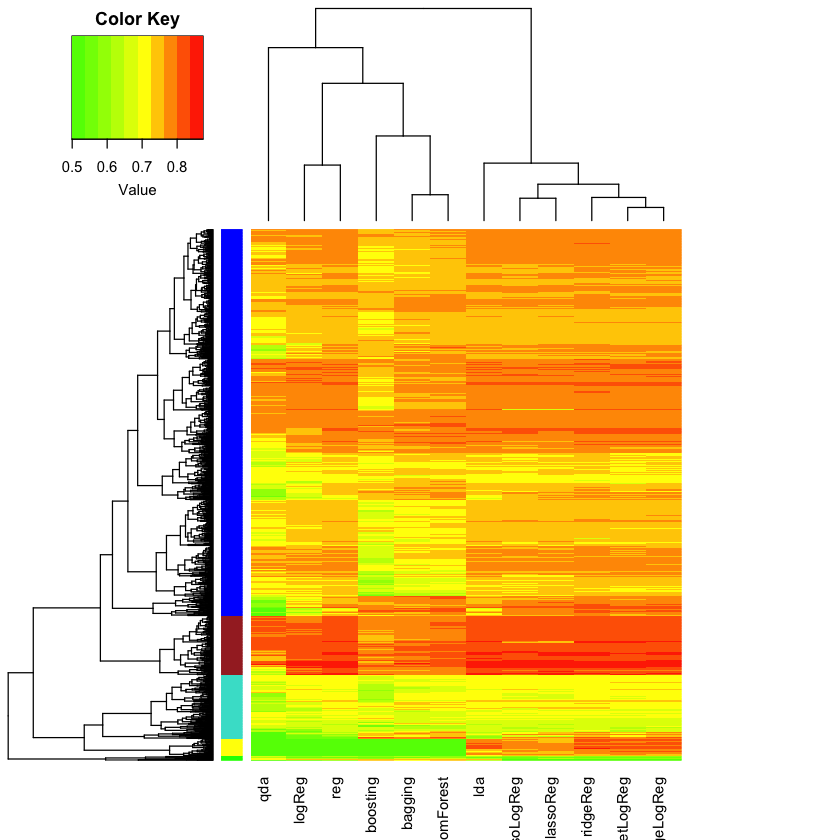

In [68]:
k=5
n=cutree(as.hclust(hm$rowDendrogram),k)
nPalette=WGCNA:::labels2colors(seq(1:k))
#nPalette[4]="black"

nPalette=nPalette[n]

#nPalette[nPalette=="brown"]="orange"

heatmap.2(as.matrix(ROCmat), margins = c(5,10),trace="none",density.info=c("none"),col=slpallete[max(round(min(ROCmat),1)*25,2):(round(max(ROCmat),2)*25)],labRow = F,RowSideColors=nPalette)
#correspondence of colors with cluster numbers
data.frame(Number=1:k,color=WGCNA:::labels2colors(seq(1:k)))

#which color?
slColor=3
slClusters=ROCmat[n==slColor,]
# get the mean of slClusters
min(apply(slClusters,1, mean))
mean(apply(slClusters,1, mean))
pathList=row.names(slClusters)

# save(pathList,file=paste0(path,"selectedPathList.rda"))

# 2.3 model AUC-ROC distribution check 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



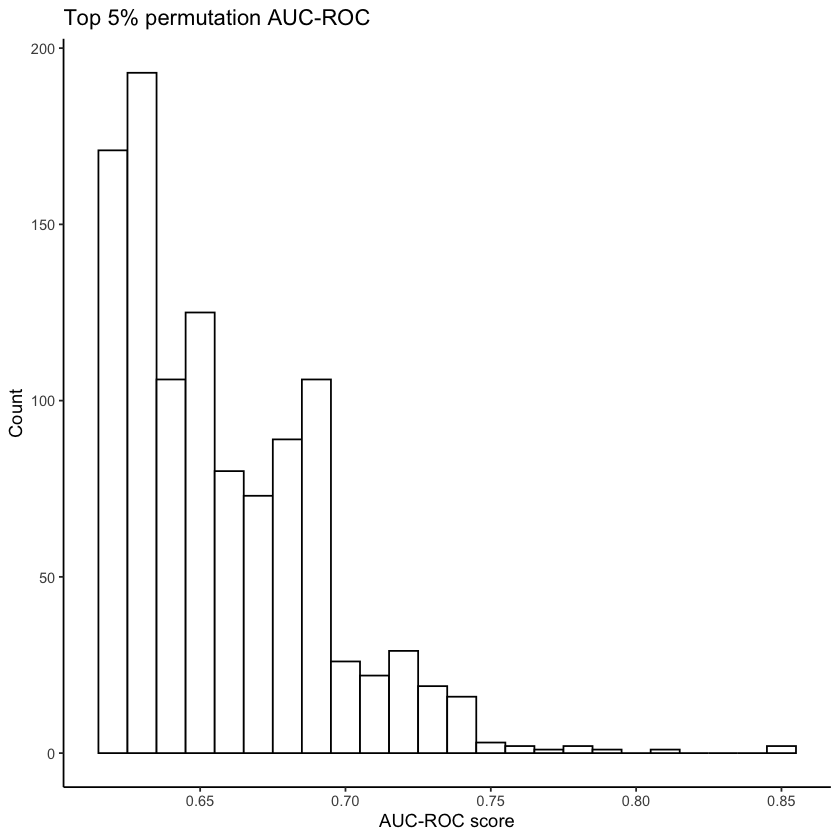

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



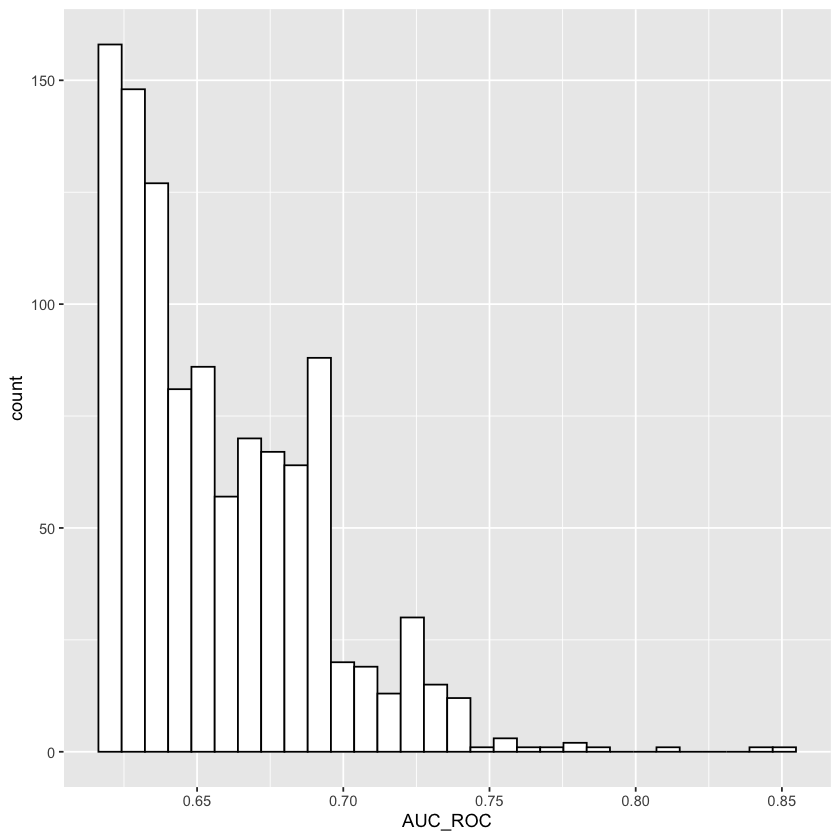

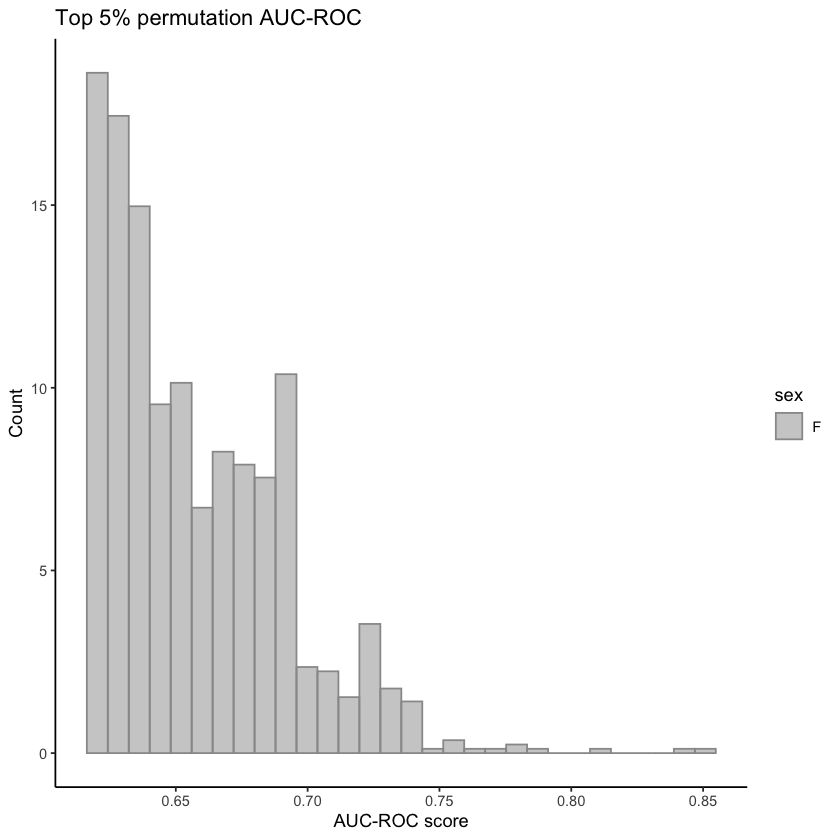

In [69]:
load(file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_all.rda")

load("/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm1/ResultsArranged.rda")
perm1=ROCres
perm1[[1]][perm1[[2]]<5]=0.5
perm1=perm1[[1]]
perm1=perm1[,-which(colnames(perm1)=="sqda")]
row.names(perm1)=gsub("perm1","real",row.names(perm1))
x=perm1
x=x[row.names(x) %in% row.names(dataMain$data$weightsROC), ]

x2=as.data.frame(which(dataMain$data$weightsROC>0.8, arr.ind = T))

# counter=0
# x2=x2[row.names(dataMain$data$weightsROC)[x2$row] %in% row.names(perm1),]
# for(i in 1:nrow(x2)){
#   if(x[row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]]]>0.8){
#     counter=counter+1
#   }
# }
# counter
perm1=PRres
perm1[[1]][perm1[[2]]<5]=0.5
perm1=perm1[[1]]
perm1=perm1[,-which(colnames(perm1)=="sqda")]

perm1_1 <- perm1[order(-perm1)]

data <- perm1_1[1:1067]

the_table_ = data.frame(value=data)
the_table_$sex='F'
ggplot(the_table_, aes(x=value)) +
  geom_histogram(fill="white", color="black",binwidth=0.01) +
  labs(title="Top 5% permutation AUC-ROC",x="AUC-ROC score", y = "Count") +
  theme_classic()

library(ggplot2)
data = data.frame("AUC_ROC"=data)
ggplot(data, aes(x=AUC_ROC)) + 
  geom_histogram(color="black", fill="white")
row.names(perm1)=gsub("perm1","real",row.names(perm1))
x=perm1
x=x[row.names(x) %in% row.names(dataMain$data$PR_values), ]

ggplot(the_table_, aes(x=value, color=sex, fill=sex)) +
geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
scale_color_manual(values=c("#999999"))+
scale_fill_manual(values=c("#999999"))+
  labs(title="Top 5% permutation AUC-ROC",x="AUC-ROC score", y = "Count")+
theme_classic()


In [84]:
# counter_pr = 0
# row.names(perm1)=gsub("perm1","real",row.names(perm1))
# x_pr=as.data.frame(which(dataMain$data$PR_values>0.8, arr.ind = T))
# x_pr=x_pr[row.names(dataMain$data$PR_values)[x_pr$row] %in% row.names(perm1),]
# nrow(x_pr)
# for(i in 1:nrow(x_pr)){
#   print(i)
#   if(x_pr[row.names(dataMain$data$PR_values)[x2$row[i]],colnames(dataMain$data$PR_values)[x2$col[i]]]>0.8){
#     counter_pr=counter_pr+1
#   }
# }
# counter_pr
# Long dataset
# Fraction of high performing paths that are in common between the main and long datasets

row.names(dataLong$data$weightsROC)=gsub("independent","real",row.names(dataLong$data$weightsROC))
x=dataLong$data$weightsROC
x=x[row.names(x) %in% row.names(dataMain$data$weightsROC),]

x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter=0
x2=x2[row.names(dataMain$data$weightsROC)[x2$row] %in% row.names(dataLong$data$weightsROC),]
for(i in 1:nrow(x2)){
  if(x[row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]]]>0.8){
    counter=counter+1
  }
}

counter_pr = 0
x_pr=dataMain$data$PR_values

for(i in 1:nrow(x2)){
  if(x_pr[row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]]]>0.8){
    counter_pr=counter_pr+1
  }

}
counter_pr
# x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

# dataMain$data$PR_values
counter/nrow(x2)
counter

#Test dataset
#Fraction of high performing paths that are in common between the main and test datasets
row.names(dataTest$data$weightsROC)=gsub("independent","real",row.names(dataTest$data$weightsROC))

x=dataTest$data$weightsROC
x=x[row.names(x) %in% row.names(dataMain$data$weightsROC),]

x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter=0
slFeatures = c()
sl_models = c()
 
x2=x2[row.names(dataMain$data$weightsROC)[x2$row] %in% row.names(dataTest$data$weightsROC),]
for(i in 1:nrow(x2)){
  if(x[row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]]]>=0.75){
    counter=counter+1
    slFeatures=c(slFeatures,row.names(dataMain$data$weightsROC)[x2$row[i]])
    sl_models=c(sl_models, paste(row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]], sep="_"))
  }
}
# sl_models
name_refined = c()
for(i in 1:length(sl_models)){
  temp_name = unlist(strsplit(sl_models[i],"_"))
  temp_name = temp_name[-1]
  temp_name=paste(temp_name,collapse = "_")
  name_refined = c(name_refined, temp_name)
}
# name_refined

x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter/nrow(x2)
counter
#LD dataset
#Fraction of high performing paths that are in common between the main and LD datasets
row.names(dataLD$data$weightsROC)=gsub("independent","real",row.names(dataLD$data$weightsROC))

x=dataLD$data$weightsROC
x=x[row.names(x) %in% row.names(dataMain$data$weightsROC),]

x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter=0
slFeatures=c()
x2=x2[row.names(dataMain$data$weightsROC)[x2$row] %in% row.names(dataLD$data$weightsROC),]
for(i in 1:nrow(x2)){
  if(x[row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]]]>=0.75){
    counter=counter+1
    slFeatures=c(slFeatures,row.names(dataMain$data$weightsROC)[x2$row[i]])
  }
}
x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter/nrow(x2)

# LD_ASD
row.names(dataLD_ASD$data$weightsROC)=paste0("real",row.names(dataLD_ASD$data$weightsROC), sep="")

x=dataLD_ASD$data$weightsROC
x=x[row.names(x) %in% row.names(dataMain$data$weightsROC),]

x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter=0
slFeatures=c()
x2=x2[row.names(dataMain$data$weightsROC)[x2$row] %in% row.names(dataLD_ASD$data$weightsROC),]
for(i in 1:nrow(x2)){
  if(x[row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]]]>=0.75){
    counter=counter+1
    slFeatures=c(slFeatures,row.names(dataMain$data$weightsROC)[x2$row[i]])
  }
}
x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter/nrow(x2)
counter


[1] 1508

[1] 0.9088913

[1] 1656

[1] 0.5905598

[1] 1076

[1] 0

[1] 0.01427003

[1] 26

Using id as id variables



pdf 
  2

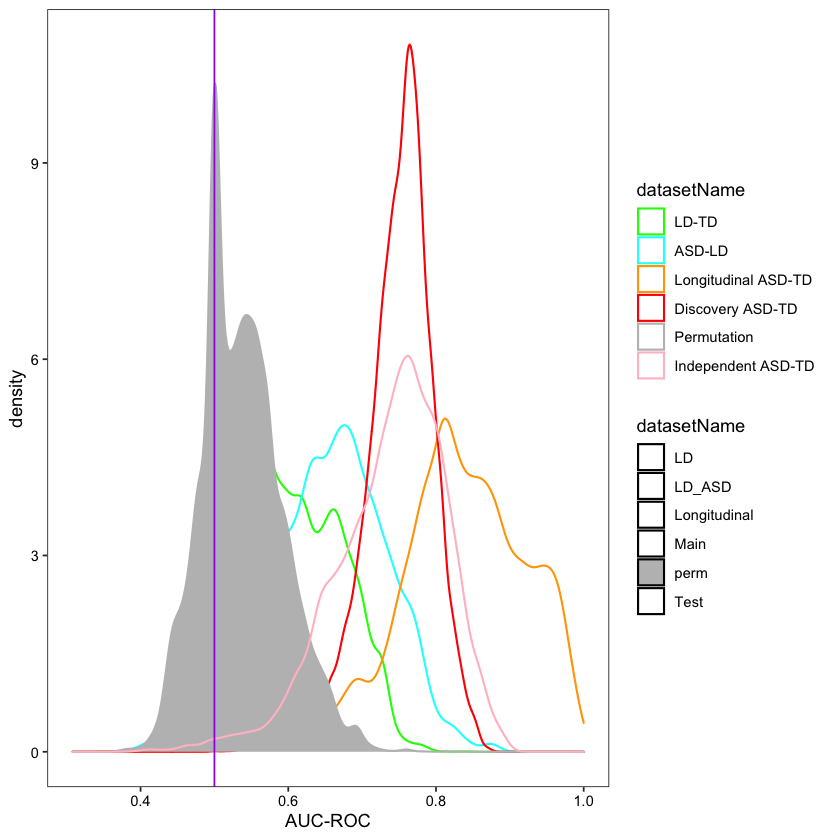

In [87]:
#density plots of model ROCs
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
load("/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/perm1/ResultsArranged.rda")
perm1=ROCres
ROCscombined=.myROCDensityDataFn()
ROCperm = perm1
ROCperm[[1]][ROCperm[[2]]<5]=0.5
ROCperm=ROCperm[[1]]
ROCperm=ROCperm[,-which(colnames(ROCperm)=="sqda")]
ROCperm=data.frame(id=row.names(ROCperm),ROCperm,stringsAsFactors = F)
ROCperm=melt(ROCperm,by="id")
ROCperm$datasetName="perm"
ROCperm$variable=as.character(ROCperm$variable)
ROCscombined$variable=as.character(ROCscombined$variable)
ROCscombined=rbind(ROCscombined,ROCperm)
#### figure 1.x perm_vs_all.pdf
ggplot(ROCscombined,aes(color=datasetName,fill=datasetName,value))+geom_density(size=0.6)+
  scale_color_manual(values=c("green",'cyan',"orange","red","gray","pink"),labels=c('LD-TD','ASD-LD', 'Longitudinal ASD-TD', 'Discovery ASD-TD', 'Permutation','Independent ASD-TD'))+scale_fill_manual(values=c(NA,NA,NA,NA,"gray",NA))+theme_bw()+theme(panel.grid = element_blank(),axis.text = element_text(color = "black"))+geom_vline(xintercept = 0.5,color="purple")+xlab("AUC-ROC")

pdf(file=paste0(inputPath,"perm_vs_all.pdf"), width = 8, height = 6)
ggplot(ROCscombined,aes(color=datasetName,fill=datasetName,value))+geom_density(size=0.6)+
  scale_color_manual(values=c("green",'cyan',"orange","red","gray","pink"),labels=c('LD-TD','ASD-LD', 'Longitudinal ASD-TD', 'Discovery ASD-TD', 'Permutation','Independent ASD-TD'))+scale_fill_manual(values=c(NA,NA,NA,NA,"gray",NA))+theme_bw()+theme(panel.grid = element_blank(),axis.text = element_text(color = "black"))+geom_vline(xintercept = 0.5,color="purple")+xlab("AUC-ROC")
  # scale_fill_discrete(name='Dataset name', )
dev.off()


pdf 
  2

pdf 
  2

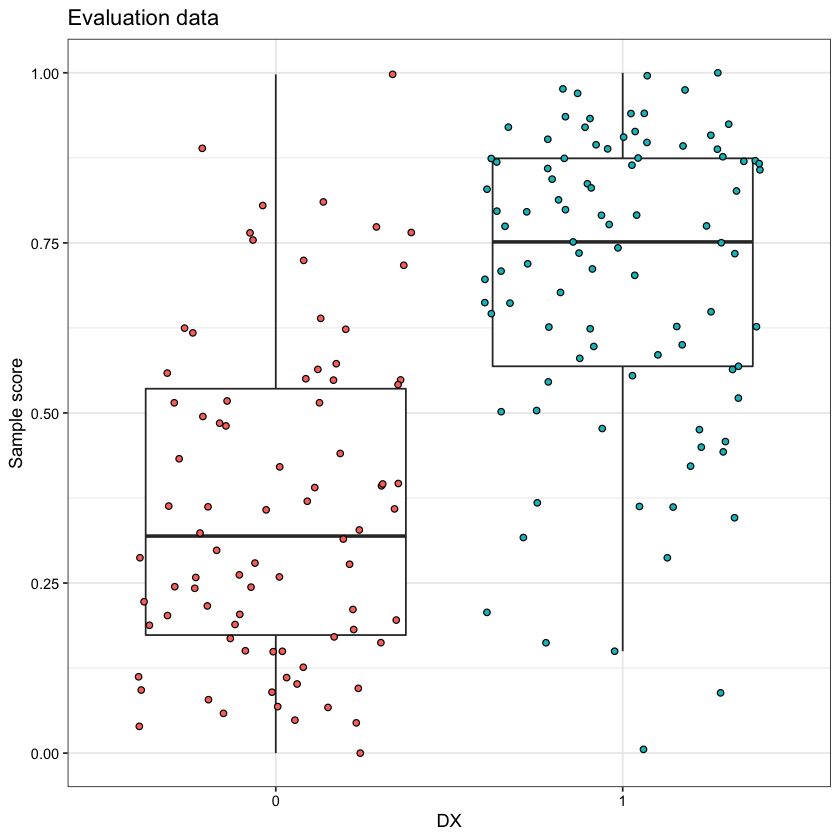

[1] 175

pdf 
  2

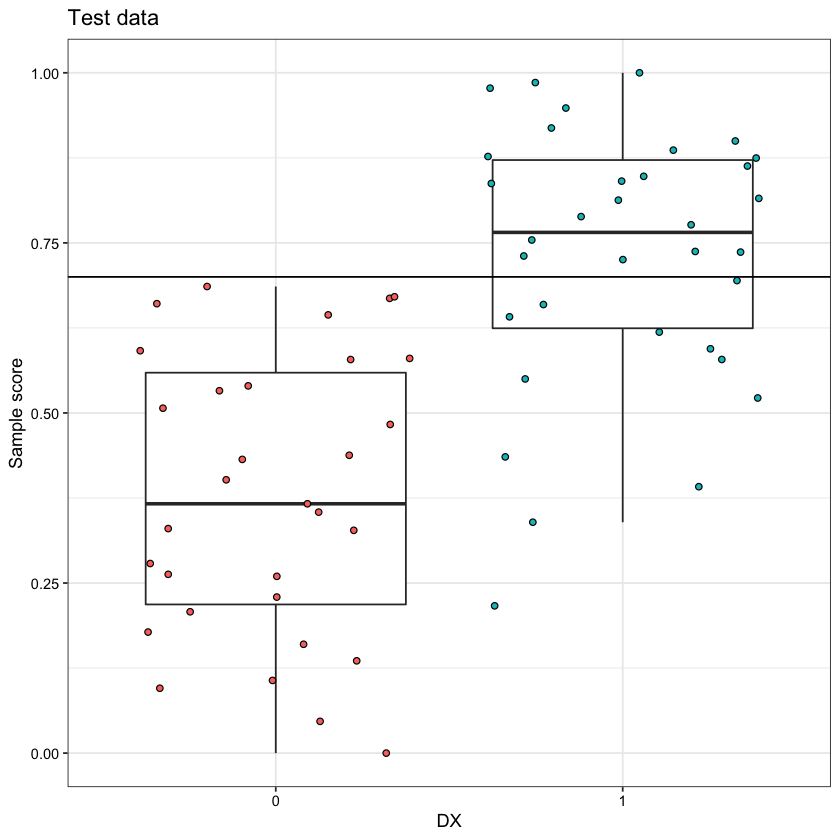

pdf 
  2

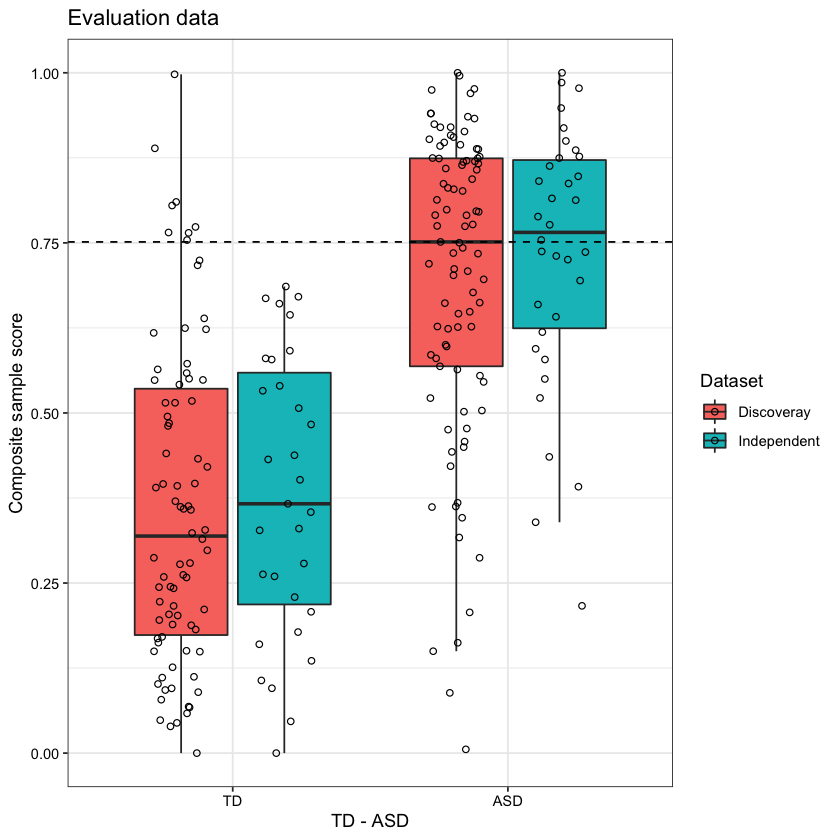

pdf 
  2

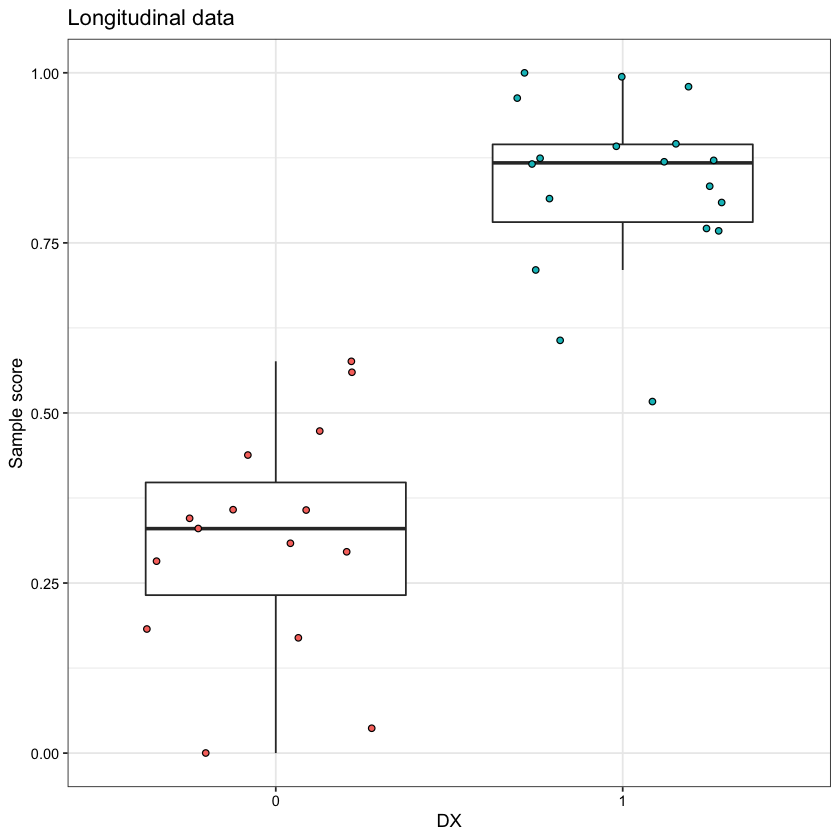

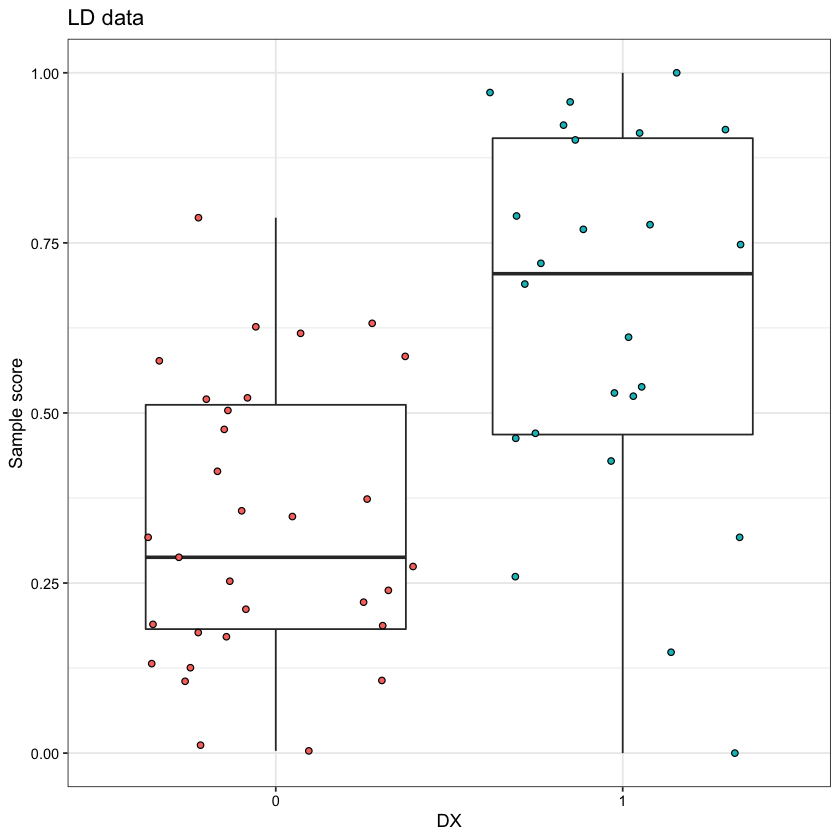

In [90]:
pdf(file=paste0(inputPath,"main_boxplot.pdf"))
ggplot(dataMain$data$concensus,aes(factor(real),weightedEstimate))+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(fill=factor(real)),width = 0.4,shape=21)+ggtitle("Evaluation data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")
dev.off()
ggplot(dataMain$data$concensus,aes(factor(real),weightedEstimate))+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(fill=factor(real)),width = 0.4,shape=21)+ggtitle("Evaluation data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")

pdf(file=paste0(inputPath,"test_boxplot.pdf"))
ggplot(dataTest$data$concensus,aes(factor(real),weightedEstimate))+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(fill=factor(real)),width = 0.4,shape=21)+ggtitle("Test data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")+geom_hline(yintercept=0.7)
dev.off()
ggplot(dataTest$data$concensus,aes(factor(real),weightedEstimate))+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(fill=factor(real)),width = 0.4,shape=21)+ggtitle("Test data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")+geom_hline(yintercept=0.7)

pdf(file=paste0(inputPath,"TandM_boxplot.pdf"))

# dataTandM$data$concensus$group='test'
# dataTandM$data$concensus$group[ which(dataTandM$data$concensus$sampleName %in% dataMain$data$concensus$sampleName)]='main'
# ggplot(dataTandM$data$concensus,aes(fill=factor(real),y=weightedEstimate, x=group), )+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(x=group),width = 0.4,shape=21)+ggtitle("Test data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")+geom_hline(yintercept=0.7)
# dev.off()
# ggplot(dataTandM$data$concensus,aes(fill=factor(real),y=weightedEstimate, x=group), )+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(x=group),width = 0.4,shape=21)+ggtitle("Test data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")+geom_hline(yintercept=0.7)


pdf(file=paste0(inputPath,"long_boxplot.pdf"))
ggplot(dataLong$data$concensus,aes(factor(real),weightedEstimate))+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(fill=factor(real)),width = 0.4,shape=21)+ggtitle("Longitudinal data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")
dev.off()
ggplot(dataLong$data$concensus,aes(factor(real),weightedEstimate))+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(fill=factor(real)),width = 0.4,shape=21)+ggtitle("Longitudinal data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")

pdf(file=paste0(inputPath,"LD_boxplot.pdf"))
ggplot(dataLD$data$concensus,aes(factor(real),weightedEstimate))+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(fill=factor(real)),width = 0.4,shape=21)+ggtitle("LD data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")
dev.off()

ggplot(dataLD$data$concensus,aes(factor(real),weightedEstimate))+geom_boxplot(outlier.shape = NA)+theme_bw()+geom_jitter(aes(fill=factor(real)),width = 0.4,shape=21)+ggtitle("LD data")+theme(legend.position = "none",axis.text = element_text(color="black"))+xlab("DX")+ylab("Sample score")


In [91]:
.myDEanalysisFn=function(inputData){
  model=model.matrix(~0+sampleLabel,data=inputData)
  colnames(model)=c("good","poor","TD")
  fit = lmFit(inputData,design=model)
  
  contrast1=makeContrasts(poor-TD,good-TD,levels=model)
  fit=contrasts.fit(fit,contrasts=contrast1)
  fit=eBayes(fit,robust = T)
  asdGood=topTable(fit,number=dim(fit)[1],coef="good - TD");
  asdPoor=topTable(fit,number=dim(fit)[1],coef="poor - TD");
  
  pvalDf=data.frame(class="good classification",pval=asdGood$P.Value,stringsAsFactors = F)
  pvalDf=rbind(pvalDf,data.frame(class="poor classification",pval=asdPoor$P.Value,stringsAsFactors = F))
  return(list(goodClassification=asdGood,poorClassification=asdPoor,pvalDist=pvalDf))
}

# load("~/Documents/archive/UCSD_data/myData/classification_paper_main_ageBalanced_05162019.rda")



ERROR: Error in expMain$sampleLabel[dataMain$data$concensus$recentDxJ_dxCode == : object 'the_median' not found
